# Flow modelling with `graph-tool`

In [114]:
import graph_tool as gt
import graph_tool.draw
import itertools as it
import numpy as np
from collections import deque

In [117]:
G = gt.load_graph("organic_flow.graphml")

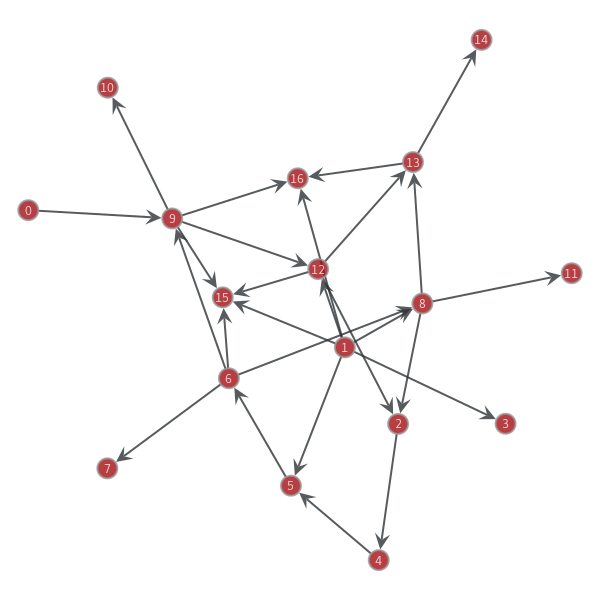

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa1567e05f8, at 0x7fa1567e0da0>

In [118]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vertex_index)

In [24]:
G.vertex_properties.keys()

['_graphml_vertex_id', 'inflow', 'outflow']

In [26]:
G.edge_properties.keys()

['_graphml_edge_id', 'flow']

In [25]:
G.list_properties()

_graphml_vertex_id (vertex)  (type: string)
inflow         (vertex)  (type: int64_t)
outflow        (vertex)  (type: int64_t)
_graphml_edge_id (edge)    (type: string)
flow           (edge)    (type: int64_t)


In [38]:
for v in G.vertices():
    print(v,
          G.vp._graphml_vertex_id[v], 
          "; inflow:", G.vp.inflow[v], 
          "; outflow:", G.vp.outflow[v])

0 Import ; inflow: 0 ; outflow: 50
1 Production ; inflow: 0 ; outflow: 85
2 Return Logistics ; inflow: 30 ; outflow: 30
3 Stock 1 ; inflow: 10 ; outflow: 10
4 Production of packaging ; inflow: 30 ; outflow: 30
5 Packaging ; inflow: 100 ; outflow: 100
6 Distribution ; inflow: 100 ; outflow: 100
7 Stock 2 ; inflow: 10 ; outflow: 10
8 Selling and Consuming ; inflow: 55 ; outflow: 55
9 Selling ; inflow: 80 ; outflow: 80
10 Stock 3 ; inflow: 10 ; outflow: 10
11 Stock 4 ; inflow: 5 ; outflow: 5
12 Consuming ; inflow: 55 ; outflow: 55
13 Collection ; inflow: 60 ; outflow: 60
14 Stock 5 ; inflow: 10 ; outflow: 10
15 Export ; inflow: 35 ; outflow: 35
16 Waste Management ; inflow: 80 ; outflow: 80


In [37]:
for e in G.edges():
    print(e, 
          "; flow:", G.ep.flow[e])

(0, 9) ; flow: 50
(1, 3) ; flow: 10
(1, 5) ; flow: 50
(1, 8) ; flow: 5
(1, 12) ; flow: 5
(1, 15) ; flow: 10
(1, 16) ; flow: 5
(2, 4) ; flow: 30
(4, 5) ; flow: 50
(5, 6) ; flow: 100
(6, 7) ; flow: 10
(6, 8) ; flow: 50
(6, 9) ; flow: 50
(6, 15) ; flow: 10
(8, 11) ; flow: 5
(8, 2) ; flow: 10
(8, 13) ; flow: 30
(9, 10) ; flow: 10
(9, 12) ; flow: 50
(9, 15) ; flow: 10
(9, 16) ; flow: 10
(12, 2) ; flow: 20
(12, 13) ; flow: 30
(12, 15) ; flow: 5
(13, 14) ; flow: 10
(13, 16) ; flow: 50


## Identifying source and sink Actory

In [40]:
for v in G.vertices():
    #print("node", v)
    nr_out = len(list(v.out_neighbors()))
    nr_in = len(list(v.in_neighbors()))
    #print("nr. out", nr_out)
    if nr_out == 0:
        print(v, G.vp._graphml_vertex_id[v], "is a sink")
    if nr_in == 0:
        print(v, G.vp._graphml_vertex_id[v], "is a source")
    for e in v.out_edges():
        #print("out edge", e)
        pass
    for w in v.out_neighbors():
        #print("out neighbor", w)
        pass

    # the edge and neighbors order always match
    for e, w in zip(v.out_edges(), v.out_neighbors()):
        assert e.target() == w

0 Import is a source
1 Production is a source
3 Stock 1 is a sink
7 Stock 2 is a sink
10 Stock 3 is a sink
11 Stock 4 is a sink
14 Stock 5 is a sink
15 Export is a sink
16 Waste Management is a sink


In [85]:
def get_sources(g):
    """Returns a numpy array"""
    a = g.get_out_degrees(g.get_vertices())
    return np.where(a == 0)[0]

In [86]:
def get_sinks(g):
    """Returns a numpy array"""
    a = g.get_in_degrees(g.get_vertices())
    return np.where(a == 0)[0]

In [84]:
len(G.get_vertices())

17

## Compute/update flows

In [121]:
def compute_stocks(g):
    src_nodes = get_sources(g).tolist()
    node_queue = deque(src_nodes)
    nr_v = len(g.get_vertices())
    props = (False for x in range(nr_v))
    vprop_visited = g.new_vertex_property("bool", vals=props)
    g.vertex_properties["visited"] = vprop_visited
    while len(node_queue) > 0:
        n = node_queue[0]
        #print(n)
        #print(G.node[n])
        succ = g.get_out_neighbors(n)
        pred = g.get_in_neighbors(n)
        node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not g.vp.visited[nbr]])
        #print(node_queue)
        out_edges = ((n, out) for out in succ)
        g.vp.outflow[n] = sum((g.ep.flow[edge] for edge in out_edges))
        if len(pred) == 0:
            g.vp.inflow[n] = 0
        else:
            in_edges = ((innode, n) for innode in pred)
            g.vp.inflow[n] = sum((g.ep.flow[edge] for edge in in_edges))
        node_queue.popleft()
        g.vp.visited[n] = True

In [122]:
G_test = G.copy()

In [123]:
%timeit compute_stocks(G_test)

3.6 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
